## 3.2 线性回归从零开始实现
这一节中，我们将从零开始实现整个方法， 包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
import random
import torch

### 3.2.1 生成数据集
简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。 我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。 我们将使用低维数据，这样可以很容易地将其可视化。在下面的代码中，我们生成一个包含1000个样本的数据集， 每个样本包含从标准正态分布中采样的2个特征。 我们的合成数据集是一个矩阵$X \in \mathcal{R}^{1000*2}$

In [2]:
def synthetic_data(w,b,num_examples):
    '''生成  y = Xw + b + 噪声'''
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w)+b
    y += torch.normal(0,0.01,y.shape)
    return X, y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)

注意，features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）。

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.1585, -0.8756]) 
label: tensor([7.4928])


通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。

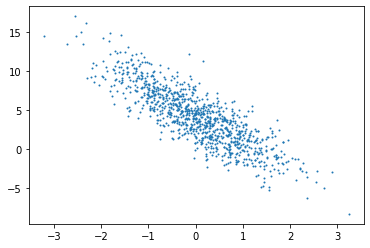

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)
plt.show()